In [1]:
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import networkx as nx
import matplotlib.patheffects as PathEffects

In [2]:
romeo_and_juliet_files = glob("../graphdata/romeo-and-juliet**")
sorted(romeo_and_juliet_files)

['../graphdata/romeo-and-juliet_ce-group-mw.edges.csv',
 '../graphdata/romeo-and-juliet_ce-group-w.edges.csv',
 '../graphdata/romeo-and-juliet_ce-scene-mw.edges.csv',
 '../graphdata/romeo-and-juliet_ce-scene-w.edges.csv',
 '../graphdata/romeo-and-juliet_ce.nodes.csv',
 '../graphdata/romeo-and-juliet_hg-group-mw.edges.csv',
 '../graphdata/romeo-and-juliet_hg-group-mw.node-weights.csv',
 '../graphdata/romeo-and-juliet_hg-scene-mw.edges.csv',
 '../graphdata/romeo-and-juliet_hg-scene-mw.node-weights.csv',
 '../graphdata/romeo-and-juliet_hg-speech-mwd.edges.csv',
 '../graphdata/romeo-and-juliet_hg-speech-wd.edges.csv',
 '../graphdata/romeo-and-juliet_hg.nodes.csv',
 '../graphdata/romeo-and-juliet_se-group-w.edges.csv',
 '../graphdata/romeo-and-juliet_se-group.nodes.csv',
 '../graphdata/romeo-and-juliet_se-scene-w.edges.csv',
 '../graphdata/romeo-and-juliet_se-scene.nodes.csv',
 '../graphdata/romeo-and-juliet_se-speech-mwd.edges.csv',
 '../graphdata/romeo-and-juliet_se-speech-wd.edges.csv',


In [3]:
def prettify_identifier(identifier):
    return identifier.replace("#","").split("_")[0]

In [4]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Palatino"
plt.rcParams["text.usetex"] = True
plt.rcParams['pdf.fonttype'] = 42

In [5]:
nodes_ce = pd.read_csv('../graphdata/romeo-and-juliet_ce.nodes.csv')
nodes_ce.node = nodes_ce.node.map(prettify_identifier)
nodes_ce = nodes_ce.query("not node.str.isupper()")

In [6]:
edges_ce_scene_mw = pd.read_csv('../graphdata/romeo-and-juliet_ce-scene-mw.edges.csv')
edges_ce_scene_mw.node1 = edges_ce_scene_mw.node1.map(prettify_identifier)
edges_ce_scene_mw.node2 = edges_ce_scene_mw.node2.map(prettify_identifier)
edges_ce_scene_mw = edges_ce_scene_mw.query("not node1.str.isupper() and not node2.str.isupper()")

In [7]:
height = 6
font_size = 16

In [18]:
def get_graph(nodes_df, edges_df):
    G = nx.Graph()
    G.add_nodes_from(nodes_df.node)
    G.add_edges_from(list(zip(edges_df.node1,edges_df.node2)))
    return G

def get_count_weighted_graph(nodes_df, edges_df):
    G = nx.Graph()
    G.add_nodes_from(nodes_df.node)
    G.add_weighted_edges_from(list(zip(edges_df.node1,edges_df.node2,edges_df["count"])))
    return G

def get_line_weighted_graph(nodes_df, edges_df):
    G = nx.Graph()
    G.add_nodes_from(nodes_df.node)
    G.add_weighted_edges_from(list(zip(edges_df.node1,edges_df.node2, edges_df.n_lines)))
    return G

## Hypergraphs

In [405]:
import hypernetx as hnx

In [406]:
def get_hypergraph(df_grouped):
    H = hnx.Hypergraph()
    for idx, row in df_grouped.iterrows():
        H.add_edge(
            hnx.Entity(
                idx,
                row["onstage"],
                **{k: v for k, v in row.items() if k != "onstage"},
            )
        )
    return H

In [537]:
hg_scene_mw_edges = pd.read_csv('../graphdata/romeo-and-juliet_hg-scene-mw.edges.csv')
hg_scene_mw_edges.onstage = hg_scene_mw_edges.onstage.map(lambda x: list(map(prettify_identifier, x.split()))).map(
    lambda onstage:[x for x in onstage if not x.isupper()])
hg_scene_mw_edges_act3 = hg_scene_mw_edges.query("act == 3").reset_index(drop=True)

In [538]:
H3 = get_hypergraph(hg_scene_mw_edges_act3)

In [539]:
node_weights3 = pd.read_csv('../graphdata/romeo-and-juliet_hg-scene-mw.node-weights.csv').query("act == 3")
node_weights3.node = node_weights3.node.map(prettify_identifier)
node_weights3 = node_weights3.groupby("node").agg(dict(n_lines_speaker=sum))
radii3 = {k:v/50 for k,v in zip(node_weights3.index, node_weights3.n_lines_speaker)}
edge_width3 = {k.uid:k.n_lines/50 for k in H3.edges()}

In [540]:
from matplotlib.text import Annotation

def draw_hypergraph(nH, node_radius, edge_width, fontsize, tax, layout_kwargs):
    pos = nx.spring_layout(nH.bipartite(), **layout_kwargs["layout_kwargs"])
    node_labels = {n.uid: n.uid for n in nH.nodes()}
    hnx.draw(
        nH,
        ax=tax,
        pos=pos,
        with_node_labels=True,
        node_radius=node_radius,
        with_edge_labels=True,
        edge_labels={k.uid:k.uid+1 for k in nH.edges()},
        edges_kwargs=dict(
            edgecolors=[cm.viridis_r(x/nH.number_of_edges()) for x in range(nH.number_of_edges())],
            lw=edge_width,dr=0.05
        ),
        edge_labels_kwargs=dict(fontsize=fontsize),
        node_labels_kwargs=dict(fontsize=fontsize),
        label_alpha=0
    )
    for child in tax.get_children():
        if isinstance(child, Annotation):
            child.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

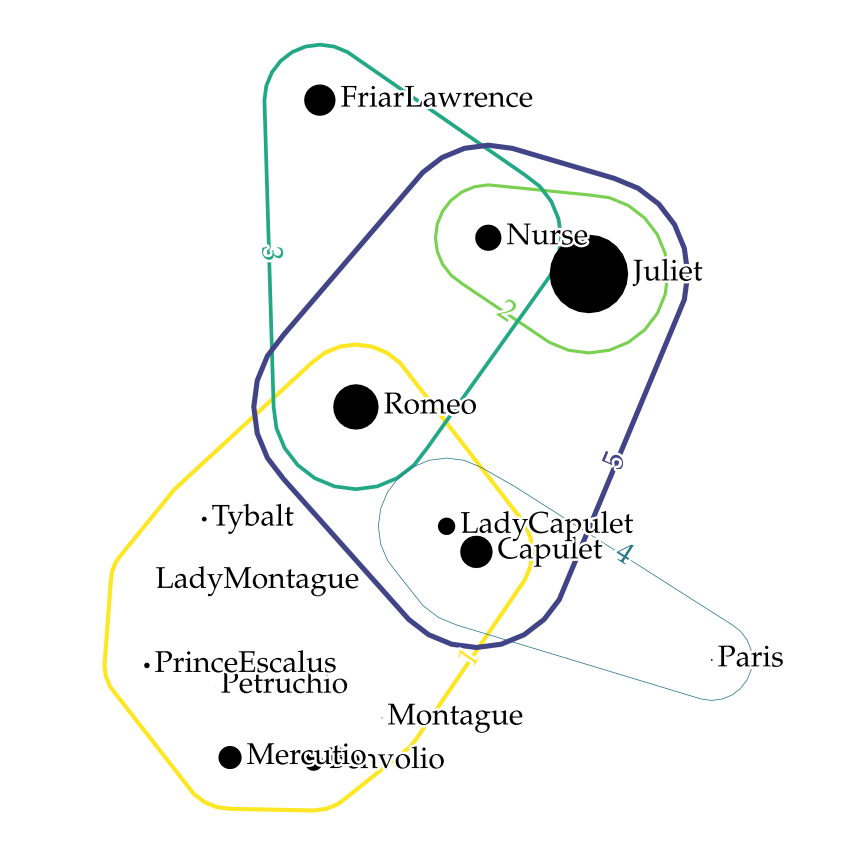

In [541]:
seed = 11
fontsize = 30
layout_kwargs = {"layout_kwargs": {"seed": seed}}
fig, ax = plt.subplots(1,1,figsize=(12,12))
draw_hypergraph(H3, radii3, edge_width3, fontsize, ax, layout_kwargs)
plt.tight_layout()
plt.savefig("romeo_and_juliet_hg-scene_3.pdf", transparent=True, bbox_inches="tight")

In [542]:
hg_group_mw_edges = pd.read_csv('../graphdata/romeo-and-juliet_hg-group-mw.edges.csv')
hg_group_mw_edges.onstage = hg_group_mw_edges.onstage.map(lambda x: list(map(prettify_identifier, x.split()))
                                                         ).map(lambda onstage:[x for x in onstage if not x.isupper()])
hg_group_mw_edges_act3 = hg_group_mw_edges.query("act == 3").reset_index(drop=True)

In [547]:
seed = 5
for scene in range(1,6):
    H3 = get_hypergraph(hg_group_mw_edges_act3.query("scene == @scene"))
    node_weights3 = pd.read_csv('../graphdata/romeo-and-juliet_hg-group-mw.node-weights.csv').query("act == 3")
    node_weights3.node = node_weights3.node.map(prettify_identifier)
    node_weights3 = node_weights3.query("scene == @scene")
    node_weights3 = node_weights3.groupby("node").agg(dict(n_lines_speaker=sum))
    radii3 = {k:v/(50/3) for k,v in zip(node_weights3.index, node_weights3.n_lines_speaker)}
    edge_width3 = {k.uid:k.n_lines/(50/3) for k in H3.edges()}
    
    seed = 11
    fontsize = 45 if scene in [2,3,4] else 30
    layout_kwargs = {"layout_kwargs": {"seed": seed}}
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    draw_hypergraph(H3, radii3, edge_width3, fontsize+6, ax, layout_kwargs)
    plt.tight_layout()
    plt.savefig(f"romeo_and_juliet_hg-group_3-{scene}.pdf", transparent=True, bbox_inches="tight")
    plt.close()

In [475]:
hg_group_mw_edges.query("act == 1 and scene == 2")

,act,scene,stagegroup,n_tokens,n_lines,onstage
12,1,2,13,302,38,"[Capulet, Paris]"
13,1,2,14,69,8,[]
14,1,2,15,260,42,"[Benvolio, Romeo]"
15,1,2,16,161,20,"[Benvolio, Romeo]"


In [472]:
hg_group_mw_edges = hg_group_mw_edges[hg_group_mw_edges.onstage.map(lambda x:len(x) < 2)]

,act,scene,stagegroup,n_tokens,n_lines,onstage
0,0,0,1,106,14,[Chorus]
13,1,2,14,69,8,[]
21,1,5,22,17,3,[]
22,1,5,23,58,8,[]
23,1,5,24,37,6,[]
31,1,5,32,13,2,[Juliet]
33,2,0,34,113,14,[Chorus]
34,2,1,35,18,2,[Romeo]
36,2,2,37,9,1,[Romeo]
38,2,2,39,22,3,[Romeo]


### Temporal

In [828]:
transformed_df.T.sort_values(14)

n_lines_cumulative,14,15,16,17,19,20,21,22,25,27,...,3132,3134,3140,3144,3149,3159,3162,3167,3169,3175
Apothecary,0.0,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.002235,0.002234,0.002229,0.002226,0.002223,0.002216,0.002214,0.002210,0.002209,0.002205
SERVANTS.MONTAGUE.Abram,0.0,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.001596,0.001595,0.001592,0.001590,0.001588,0.001583,0.001581,0.001579,0.001578,0.001575
SERVANTS.CAPULET.Sampson,0.0,0.066667,0.0625,0.117647,0.105263,0.15,0.142857,0.181818,0.16,0.222222,...,0.011175,0.011168,0.011146,0.011132,0.011115,0.011079,0.011069,0.011051,0.011044,0.011024
SERVANTS.CAPULET.Peter,0.0,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.011175,0.011168,0.011146,0.011132,0.011115,0.011079,0.011069,0.011051,0.011044,0.011024
SERVANTS.CAPULET.Gregory,0.0,0.000000,0.0625,0.058824,0.157895,0.15,0.190476,0.181818,0.28,0.259259,...,0.007663,0.007658,0.007643,0.007634,0.007621,0.007597,0.007590,0.007578,0.007573,0.007559
Romeo,0.0,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.199234,0.199107,0.198726,0.198473,0.198158,0.197531,0.197343,0.197032,0.196908,0.196535
PrinceEscalus,0.0,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.017880,0.018507,0.018471,0.019720,0.019689,0.022792,0.022770,0.022734,0.022720,0.024567
Petruchio,0.0,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.000319,0.000319,0.000318,0.000318,0.000318,0.000317,0.000316,0.000316,0.000316,0.000315
Paris,0.0,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.022350,0.022336,0.022293,0.022265,0.022229,0.022159,0.022138,0.022103,0.022089,0.022047
Nurse,0.0,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.091635,0.091576,0.091401,0.091285,0.091140,0.090852,0.090765,0.090622,0.090565,0.090394


In [829]:
hg_speech_mwd = pd.read_csv('../graphdata/romeo-and-juliet_hg-speech-mwd.edges.csv')
hg_speech_mwd.speaker = hg_speech_mwd.speaker.map(lambda x:[y for y in map(prettify_identifier, x.split()) if not y.isupper() and not y.startswith("SERVANT")])
hg_speech_mwd.onstage = hg_speech_mwd.onstage.map(lambda x:[y for y in map(prettify_identifier, x.split()) if not y.isupper() and not y.startswith("SERVANT")])

In [830]:
hg_speech_mwd["n_lines_cumulative"] = hg_speech_mwd.n_lines.cumsum()

In [831]:
hg_speech_mwd_exploded_speaker = hg_speech_mwd.explode("speaker")

In [832]:
speaker_df = pd.DataFrame(index=sorted({elem for sublist in hg_speech_mwd.speaker for elem in sublist}), columns=hg_speech_mwd.n_lines_cumulative)

In [833]:
for line in hg_speech_mwd.n_lines_cumulative:
    queried = hg_speech_mwd_exploded_speaker.query("n_lines_cumulative <= @line").groupby("speaker").agg(dict(n_lines=sum))
    for idx,n_lines in queried.n_lines.items():
        speaker_df.at[idx,line] = n_lines/line

In [834]:
transformed_df = speaker_df.T[[x for x in speaker_df.index if x != "Chorus"]].fillna(0)
transformed_df.head()

,Apothecary,Benvolio,Capulet,Cousin,FriarJohn,FriarLawrence,Juliet,LadyCapulet,LadyMontague,Mercutio,Montague,Nurse,Paris,Petruchio,PrinceEscalus,Romeo,Tybalt
n_lines_cumulative,,,,,,,,,,,,,,,,,
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [835]:
transformed_df

,Apothecary,Benvolio,Capulet,Cousin,FriarJohn,FriarLawrence,Juliet,LadyCapulet,LadyMontague,Mercutio,Montague,Nurse,Paris,Petruchio,PrinceEscalus,Romeo,Tybalt
n_lines_cumulative,,,,,,,,,,,,,,,,,
14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,0.002216,0.050965,0.086420,0.000950,0.004115,0.113644,0.176322,0.037037,0.000950,0.085154,0.011396,0.090852,0.022159,0.000317,0.022792,0.197531,0.011713
3162,0.002214,0.050917,0.087287,0.000949,0.004111,0.113536,0.176154,0.037002,0.000949,0.085073,0.011385,0.090765,0.022138,0.000316,0.022770,0.197343,0.011701
3167,0.002210,0.050837,0.087149,0.000947,0.004105,0.113356,0.175876,0.036943,0.000947,0.084938,0.012946,0.090622,0.022103,0.000316,0.022734,0.197032,0.011683


In [836]:
def get_color(k):
    if k == "Romeo":
        return cm.tab10(1)
    if k == "Juliet":
        return cm.tab10(3)
    if k == "Nurse":
        return cm.tab10(2)
    if k == "Capulet":
        return cm.tab10(0)
    if k == "LadyCapulet":
        return cm.tab10(4)
    else:
        return "k"

In [858]:
selected_labels_here = sorted(['Romeo', 'Juliet', 'Nurse', 'Capulet', 'LadyCapulet'])

In [859]:
import numpy as np

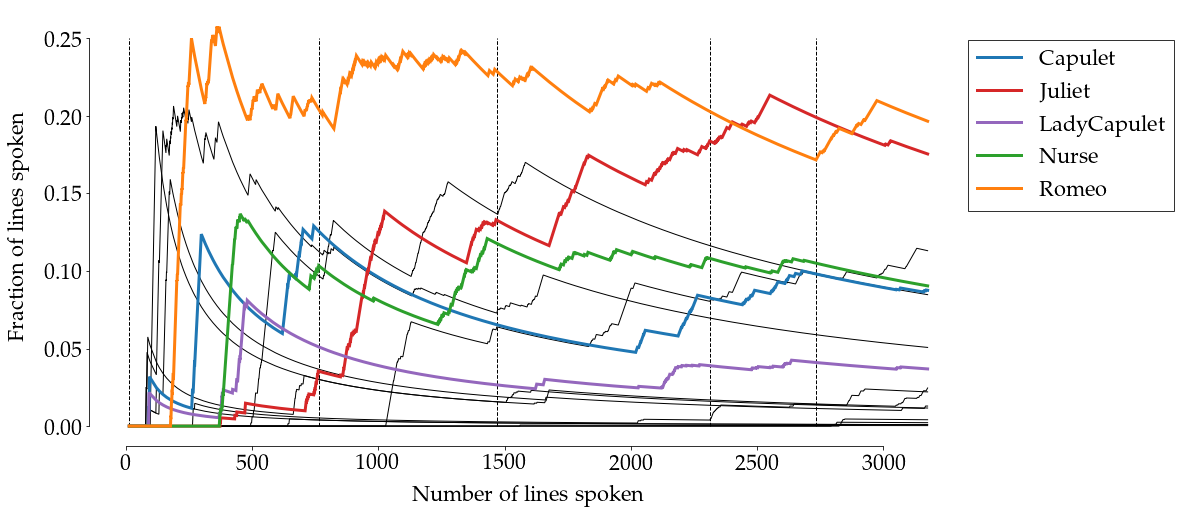

In [881]:
fig, ax = plt.subplots(1,1,figsize=(16,7))
ax.vlines(x=[hg_speech_mwd.query("act == @act").n_lines_cumulative.max() for act in range(0,5)], 
          lw=1,
          ymin=0, ymax=0.25, colors='k', linestyles="--")
transformed_df[[c for c in transformed_df.columns if c not in selected_labels_here]
              ].plot.line(ax=ax, color={k:get_color(k) for k in transformed_df.columns}, lw=1, linestyle="-", legend=False)
transformed_df[selected_labels_here].plot.line(ax=ax, color={k:get_color(k) for k in transformed_df.columns}, linestyle="-", lw=3)
sns.despine(offset=0, trim=True)
handles, labels = ax.get_legend_handles_labels()
plt.xticks(range(0,hg_speech_mwd.n_lines_cumulative.max(),500), fontsize=font_size+6)
plt.yticks(np.arange(0,0.26,0.05), fontsize=font_size+6)
legend = ax.legend(handles=handles[-5:], labels=labels[-5:], loc=(1.001,0.535), fontsize=font_size+6)
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_boxstyle("square", pad=0)
plt.tight_layout()
plt.xlabel("Number of lines spoken", fontsize=font_size+6, labelpad=9)
plt.ylabel("Fraction of lines spoken", fontsize=font_size+6, labelpad=15)
plt.savefig("romeo_and_juliet_hg-speech-over-time.pdf", transparent=False, bbox_inches="tight")

In [887]:
hg_speech_mwd[hg_speech_mwd.speaker.map(lambda x:"Juliet" in x)].n_lines.sum()

557

In [888]:
hg_speech_mwd[hg_speech_mwd.speaker.map(lambda x:"Romeo" in x)].n_lines.sum()

624

In [906]:
pd.read_csv('../graphdata/romeo-and-juliet_se-speech-wd.edges.csv')#.groupby("source").agg(dict(n_lines=sum)
                                        #).sort_values("n_lines", ascending=False).query("source.str.startswith('#')")

,source,target,n_lines,n_tokens,edge_type
0,#Apothecary_Rom,5.01.0113,7,53,active
1,#Benvolio_Rom,1.01.0004,2,12,active
2,#Benvolio_Rom,1.01.0005,2,19,active
3,#Benvolio_Rom,1.01.0010,26,197,active
4,#Benvolio_Rom,1.01.0011,2,17,active
...,...,...,...,...,...
730,5.03.0129,#SERVANTS.PARIS.1_Rom,101,787,passive
731,5.03.0129,#WATCHMEN.0.1_Rom,106,832,passive
732,5.03.0129,#WATCHMEN.0.2_Rom,106,832,passive
733,5.03.0129,#WATCHMEN.0.3_Rom,106,832,passive


In [907]:
pd.read_csv('../graphdata/romeo-and-juliet_se-speech-mwd.edges.csv')

,source,target,key,n_lines,n_tokens,edge_index,edge_type
0,#Chorus_Rom,0.00.0001,0,14,106,1,active
1,#SERVANTS.CAPULET.Sampson_Rom,1.01.0002,0,1,8,2,active
2,1.01.0002,#SERVANTS.CAPULET.Gregory_Rom,0,1,8,2,passive
3,#SERVANTS.CAPULET.Gregory_Rom,1.01.0002,0,1,7,3,active
4,1.01.0002,#SERVANTS.CAPULET.Sampson_Rom,0,1,7,3,passive
...,...,...,...,...,...,...,...
3474,5.03.0129,#SERVANTS.PARIS.1_Rom,15,6,49,858,passive
3475,5.03.0129,#WATCHMEN.0.1_Rom,16,6,49,858,passive
3476,5.03.0129,#WATCHMEN.0.2_Rom,16,6,49,858,passive
3477,5.03.0129,#WATCHMEN.0.3_Rom,16,6,49,858,passive
